In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import os
import glob
import cv2
import random
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint   
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from datetime import date

tf.config.list_physical_devices('GPU')

Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
PATH = '/home/fabio/Documentos/TCC/chest_xray/'
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 16

dados_treinamento = glob.glob(PATH + 'train/**/*.jpeg')
dados_teste = glob.glob(PATH + 'test/**/*.jpeg')
dados_validacao = glob.glob(PATH + 'val/**/*.jpeg')

print("-------------------------------------------------------------------")
print("Total de imagens para treinamento: " + str(len(dados_treinamento)))
print("Total de imagens para teste: " + str(len(dados_teste)))
print("Total de imagens para validação: " + str(len(dados_validacao)))
print("-------------------------------------------------------------------")

-------------------------------------------------------------------
Total de imagens para treinamento: 5216
Total de imagens para teste: 624
Total de imagens para validação: 16
-------------------------------------------------------------------


In [3]:
data_sets = ["train", "test", "val"]
imagens_pneumonia = []
imagens_normais = []

for it in data_sets:
    path = os.path.join(PATH, it)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    imagens_normais.extend(normal)
    imagens_pneumonia.extend(pneumonia)

print("-------------------------------------------------------------------")
print("Total de imagens com pneumonia:" + str(len(imagens_pneumonia)))
print("Total de imagens normais:" + str(len(imagens_normais)))
print("-------------------------------------------------------------------")

-------------------------------------------------------------------
Total de imagens com pneumonia:4273
Total de imagens normais:1583
-------------------------------------------------------------------


In [4]:
rotulos = ['Pneumonia ', "Normal"]
valores = [len(imagens_pneumonia), len(imagens_normais)]
cores = ['royalblue', 'cyan']
fig = go.Figure(data=[go.Pie(labels=rotulos, values=valores, hole=.0)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20, marker=dict(colors=cores))
fig.update_layout(title="Distribuição das amostras", titlefont={'size': 30})
iplot(fig)

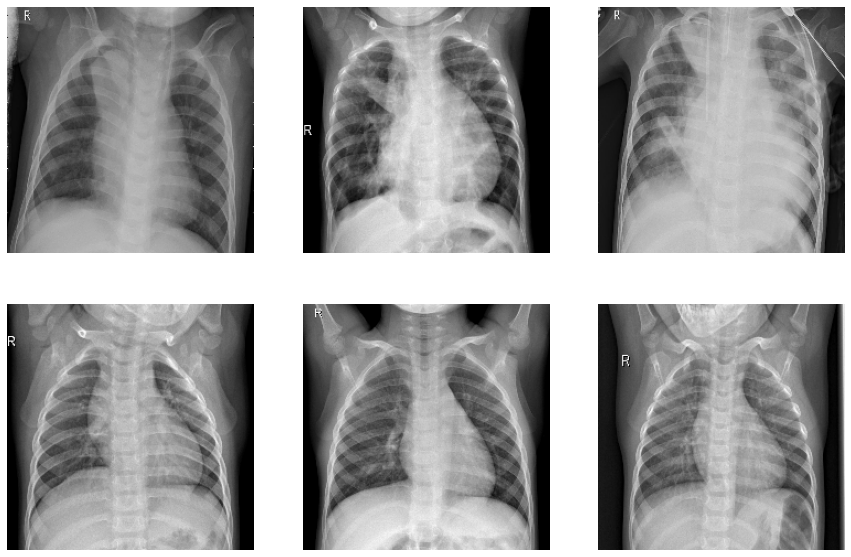

In [5]:
images = imagens_pneumonia[:4] + imagens_normais[:4]
fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, IMG_SIZE)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

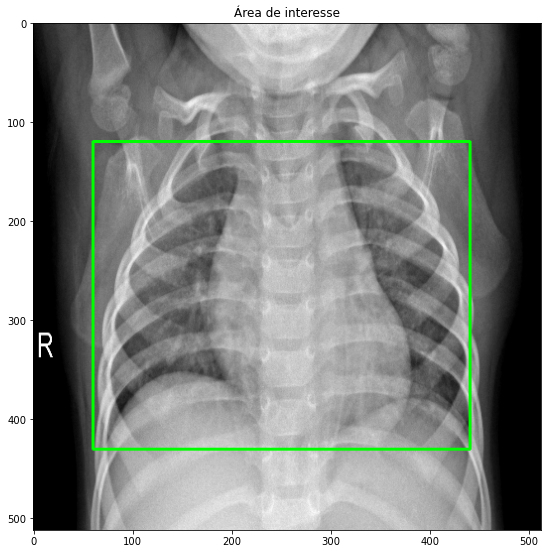

In [6]:
# Analise de distorções
corte = 70
indice = 10
figure = plt.figure(figsize=(20, 15))
img = cv2.imread(imagens_normais[indice])
img = cv2.resize(img, (512, 512))
figure.add_subplot(1, 2, 1, title="Área de interesse")
#cv2.rectangle(img,(0,235),(25,275),(250,0,0),2)
cv2.rectangle(img,(60,120),(440,430),(0,255,0),2)
plt.imshow(img)

In [7]:
data_generator = ImageDataGenerator(
    rescale=1/255., validation_split=0.30)

In [8]:
train_generator = data_generator.flow_from_directory(
    PATH + "train",
    class_mode="binary",
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE)

validation_generator = data_generator.flow_from_directory(
    PATH + "val",
    class_mode="binary",
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE)

test_generator = data_generator.flow_from_directory(
    PATH + "test",
    class_mode="binary",
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


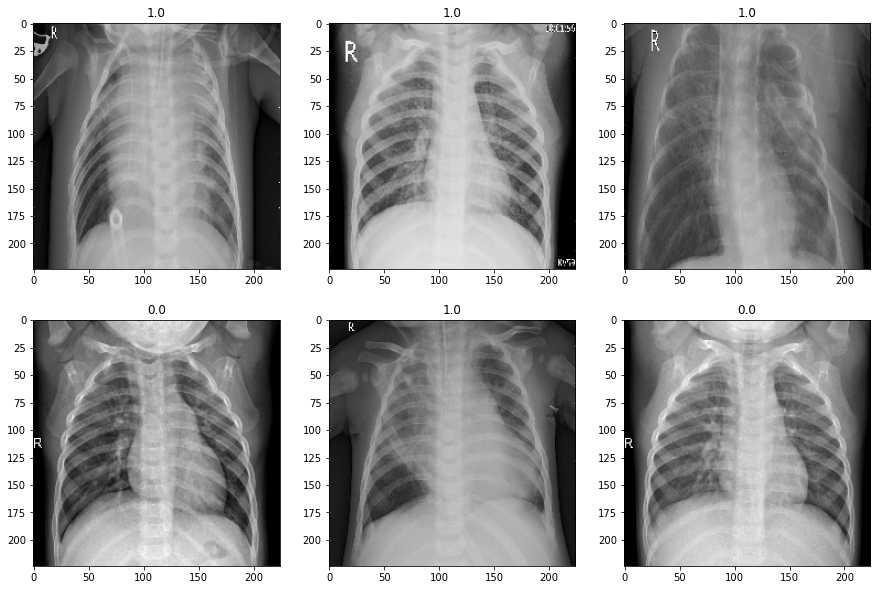

In [9]:
fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 2
for i in range(1, columns*rows +1):
    img, label = train_generator.next()    
    fig.add_subplot(rows, columns, i, title=label[i])
    plt.imshow(img[i])

In [ ]:
model = Sequential()
# Primeira camada
model.add(Conv2D(filters=32, kernel_size=2, activation='relu', input_shape=IMG_SHAPE))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Segunda camada
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Terceira camada
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Quarta camada
model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

# Transforma em array para fully connected
model.add(Flatten())

# Primeira camada fully connected
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Segunda camada fully connected
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Camada de resultado
model.add(Dense(2, activation='softmax'))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Salvar o modelo com melhor loss durante o treinamento 
checkpointer = ModelCheckpoint(filepath=PATH + "../modelos/model.weights.best.hdf5",
                                monitor="val_loss",
                                verbose=1,
                                mode="min",
                                save_best_only=True)

# Interompe o treinamento quando o resultado começar a piorar
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                min_delta=0.001,
                                patience=5,
                                mode="min",
                                verbose=1)


history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.samples//BATCH_SIZE,
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples//BATCH_SIZE,
                                epochs=50,
                                verbose=1,    
                                callbacks=[checkpointer,early_stop])

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [89]:
# Carrega o melhor modelo
model = tf.keras.models.load_model("/home/fabio/Documentos/TCC/modelos/model.weights.best.hdf5")

In [90]:
# Carrega as imagens para teste
image_test = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_name, target_size=(224,224),color_mode='rgb'))/255 for image_name in dados_teste])

(1, 224, 224, 3)


In [92]:
# Aplica os testes
y_pred = model.predict(image_test)
y_pred = np.argmax(y_pred, axis=1)

In [93]:
# Cria matrix de confusão
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

<Figure size 432x288 with 0 Axes>

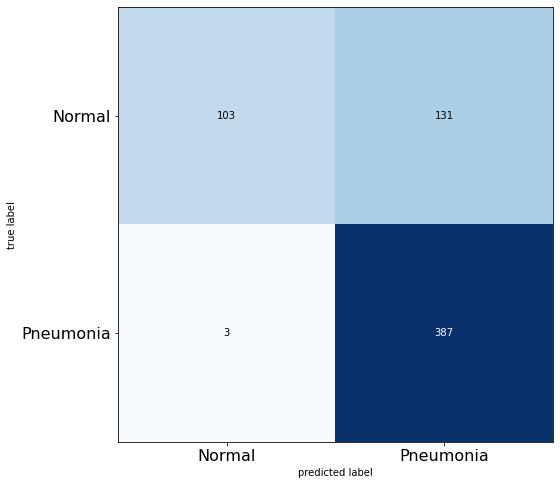

In [14]:
# Imprime a matrix de confusão
plt.figure()
plot_confusion_matrix(conf_matrix,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [94]:
print('Classification Report')
target_names = ['Normal','Pneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Normal       0.97      0.44      0.61       234
   Pneumonia       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



In [104]:
img = image_test[1]
teste_unitario = np.expand_dims(img,0)
print(teste_unitario.shape)

(1, 224, 224, 3)


In [107]:
y_pred = model.predict(teste_unitario)

In [108]:
print(y_pred)

[[0.6979998 0.3020002]]


In [115]:
print(str(y_pred[0]))

[0.6979998 0.3020002]
